# Введение

В этом проекте мы будем делать модель предсказания температуры стали для металургического завода. 

Конечной целью заказчика является снижение расходов на электроэнергию при выплавке сталелитейной продукции, а также снижение износа плавильного оборудования. 

Прогнозируя температуру стали исходя из факторов производственного процесса, модель поможет избежать перегрева металла. Также будет полезно, если мы в процессе выявим факторы, которые значительно влияют на изменение температуры сплава.

У нас в распоряжении есть данные и описание производственного процесса: все фазы подогрева, все легирующие добавки, их количество и время добавления, тип и количество проволоки, а также время ее добавления и, наконец, количество газа, потраченное для перемешивания  металла. 

Нашей целевой метрикой является MAE <= 6,8 градусов. Предварительно, думаю, это более чем реально. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm import tqdm
from tqdm import notebook

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

import time

In [3]:
RANDOM_STATE = 220523

Рэндом стэйт мы, пожалуй, укажем сразу, потому что это константа и одно из требований проекта.

# Просмотр таблиц

In [4]:
try:
    arc = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_arc_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [5]:
try:
    arc = pd.read_csv('/datasets/data_arc_new.csv')
    bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('/datasets/data_gas_new.csv')
    temp = pd.read_csv('/datasets/data_temp_new.csv')
    wire = pd.read_csv('/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except FileNotFoundError:
    print('Error: Files not found. Please provide the correct file path.')

Error: Files not found. Please provide the correct file path.


In [6]:
display(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


оК. Arc - это дуга, которая используется для нагревания (интересно, имееются в виду электроды из ковша или некие дуговые печти). Про дуговые печи я прочитал, что это хороший инструмент, который дает очень большую гибкость кастаельно используемой мощности, к тому же довольно эффективный в нагревании и также позволяющий перерабатывать и очищать металолом. 

что касается реактивной мощности, хотелось бы понимать, приведена ли одна к той же единице исчисления, что и активная мощность ли нет. Конечно, не то чтобы это суперважно, потму что модели без разницы, что считать. Она переварит все, это скорее, важнее было бы для нашего понимания... или нет. 

Что мы тут можем сделать/узнать? Идей у меня несколько. Для начала можно посчитать показатели:  1)полная мощность S = √(P² + Q²) 2)Коэффициент мощности PF = P / S , который отражает эффективность использования мощности. Во-вторых, можно соотнести эти показатиели с количеством времени, затраченного на нагревание. Возможно, это будет бесполезно, если каждый раз дуга включается с разной мощностью, так что сначала, думаю, есть смысл изучить другие таблицы, а потом уже перейти к расчетам и графикам. Как минимум хорошо уже то, что есть хоть какие-то идеи. 

In [7]:
try:
    bulk = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_bulk_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [8]:
display(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


array([[<Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'Bulk 1'}>,
        <Axes: title={'center': 'Bulk 2'}>,
        <Axes: title={'center': 'Bulk 3'}>],
       [<Axes: title={'center': 'Bulk 4'}>,
        <Axes: title={'center': 'Bulk 5'}>,
        <Axes: title={'center': 'Bulk 6'}>,
        <Axes: title={'center': 'Bulk 7'}>],
       [<Axes: title={'center': 'Bulk 8'}>,
        <Axes: title={'center': 'Bulk 9'}>,
        <Axes: title={'center': 'Bulk 10'}>,
        <Axes: title={'center': 'Bulk 11'}>],
       [<Axes: title={'center': 'Bulk 12'}>,
        <Axes: title={'center': 'Bulk 13'}>,
        <Axes: title={'center': 'Bulk 14'}>,
        <Axes: title={'center': 'Bulk 15'}>]], dtype=object)

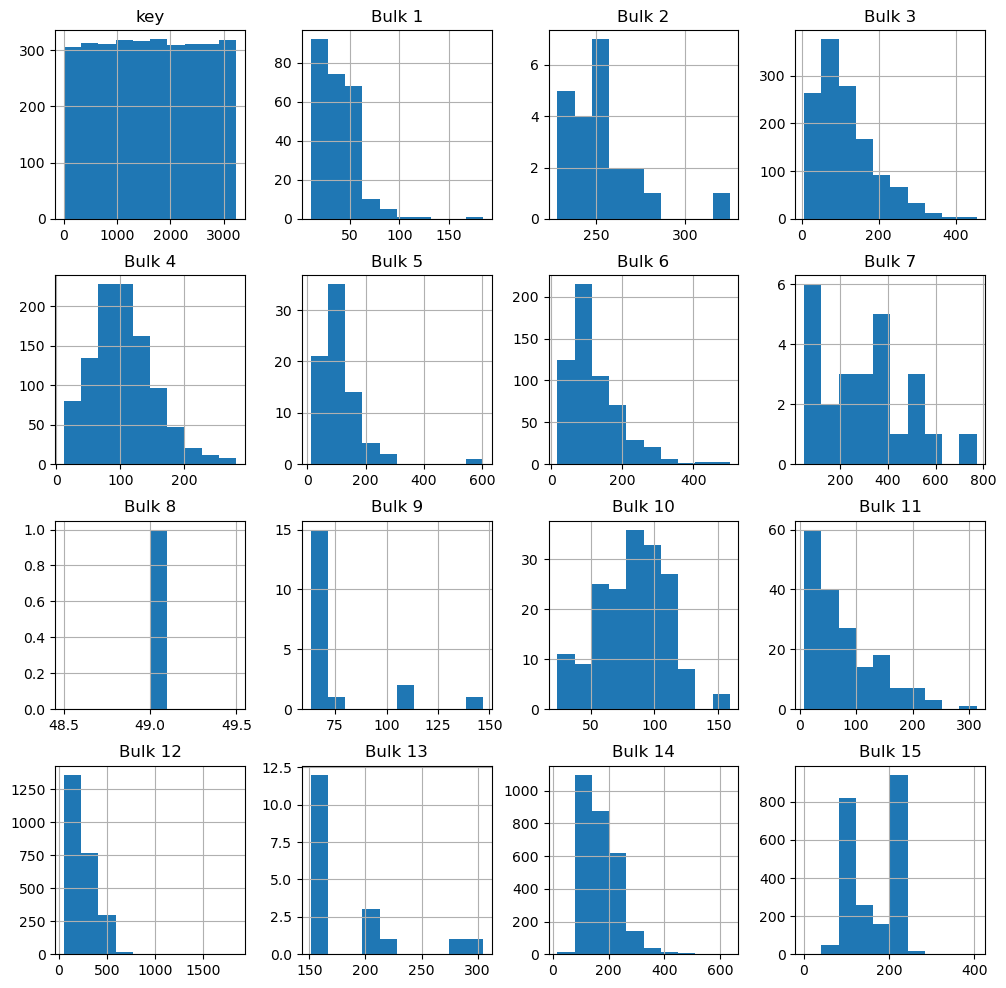

In [9]:
bulk.hist(figsize=(12,12))

Вот где пока ничего не понятно. В контексте сталелитейного завода термин «bulk» может относиться к материалам или веществам, которые транспортируются или обрабатываются в больших количествах, из чего можно сделать предположение, что у нас в произведстве участвуют 15 различных элементов, которые поэтапоно (хотя насчет порядка не уверен) добавляются нашу расплавленную смесь, чтобы получить итоговый продукт. 

Какие продукты там добавляются мы не знаем. 

Также мы не знаем, что предстваляют собой объекты. Если в прошлой таблице это были нагревательные сессии, то сейчас я не имею исчерпывающего понимания. Следует расспросить про эту таблицу на встрече с заказчиком. 

UPd. С объектами теперь стало понятно - это произведенные партии.

Если обратить внимание на гистограммы, то можно порадоваться, что они есть;)) 

А если без шуток, то мы элементарно узнаем, что какие-то присадки добавляются чаще, какие-то реже, каких-то нужно больше, каких-то меньше? Зачем оно нам? А чтобы понять, что нам это не важно и ничего необычного тут нет. Тем более нам даже названия присадок не дают, так что мы просто обработаем эти данные и добавим в котел нашей модели. И под обработаем я имею в виду всего лишь "удалим неактуальные партии".

In [10]:
try:
    bulk_time = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_bulk_time_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [11]:
display(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [12]:
#bulk_time.info()

In [13]:
bulk_columns = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

оК. Есть понимание, что эти 2 таблицы связаны. Получается, в таблице bulk количество, а в bulk_time время каждого добавления каждого элемента. Я был прав, что порядок не определен, но по идее это и не важно. Что еще примечательно, у нас есть таймлайн, по которому можно понять, что каждому "балку" предшествует нагревание.  

Upd. Судя по описанию, скорее всего, это легирующие добавки.  При чем не все, а те, которые подаются их бункера для сыпучих материалов. 

Пока что в голову приходит только одна идея - сделать какую-то таблицу с общим таймлайном, где будут как нагревания, так и добавления элементов. Зачем  она нужна? я пока не знаю, но лучше такая идея, чем никакой. 

In [14]:
try:
    gas = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_gas_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [15]:
display(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


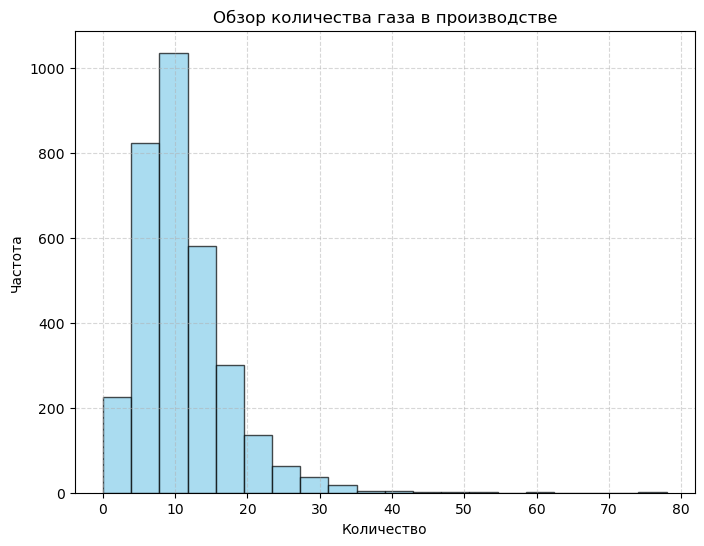

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(gas['Газ 1'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Количество')
plt.ylabel('Частота')
plt.title('Обзор количества газа в производстве')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Пока снова ничего не понятно, но хорошая новость в том, что количество объектов такое же, как и в двух предыдущих таблицах, так что можем предположить, что это количество газа, требуемое для выработки энергии. Или, может, это какой-то катализатор?  

Оказалось, что газ-это катализатор, используемый для смешивания. Из гистограммы можем узнать, что в среднем используемо количество газа будет 10, медиана, наверняка, такая же. Кроме того мы можем увидеть наличие выбросов. Будем держать его в уме, но ближе их изучим (и при необходимости избавимся), возможно, уже после объединения таблиц. 

В теории мы можем проверить - посчитать корреляцию по ключам количества газа и суммарного расхода мощности, чтобы это проверить. Но для начала продолжим изучать таблицы, а сюда вернемся позже. 

In [17]:
try:
    temp = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_temp_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [18]:
display(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Визуально есть ощущение, что температуру замеряют перед каждым нагреванием, но не сразу после него/ в процессе. То есть если я правильно понимаю, греют они примерно на глаз. Интерсно, а как они определяют, сколько надо греть и/или до какой температуры?  

Вообще, если честно, я не особо верю, что за 5 минут рабочие способны взять пробы и провести полный химический анализ. Похоже, нам немного преукрашивают ситуацию. 

In [19]:
try:
    wire = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_wire_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [20]:
display(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'Wire 1'}>,
        <Axes: title={'center': 'Wire 2'}>],
       [<Axes: title={'center': 'Wire 3'}>,
        <Axes: title={'center': 'Wire 4'}>,
        <Axes: title={'center': 'Wire 5'}>],
       [<Axes: title={'center': 'Wire 6'}>,
        <Axes: title={'center': 'Wire 7'}>,
        <Axes: title={'center': 'Wire 8'}>],
       [<Axes: title={'center': 'Wire 9'}>, <Axes: >, <Axes: >]],
      dtype=object)

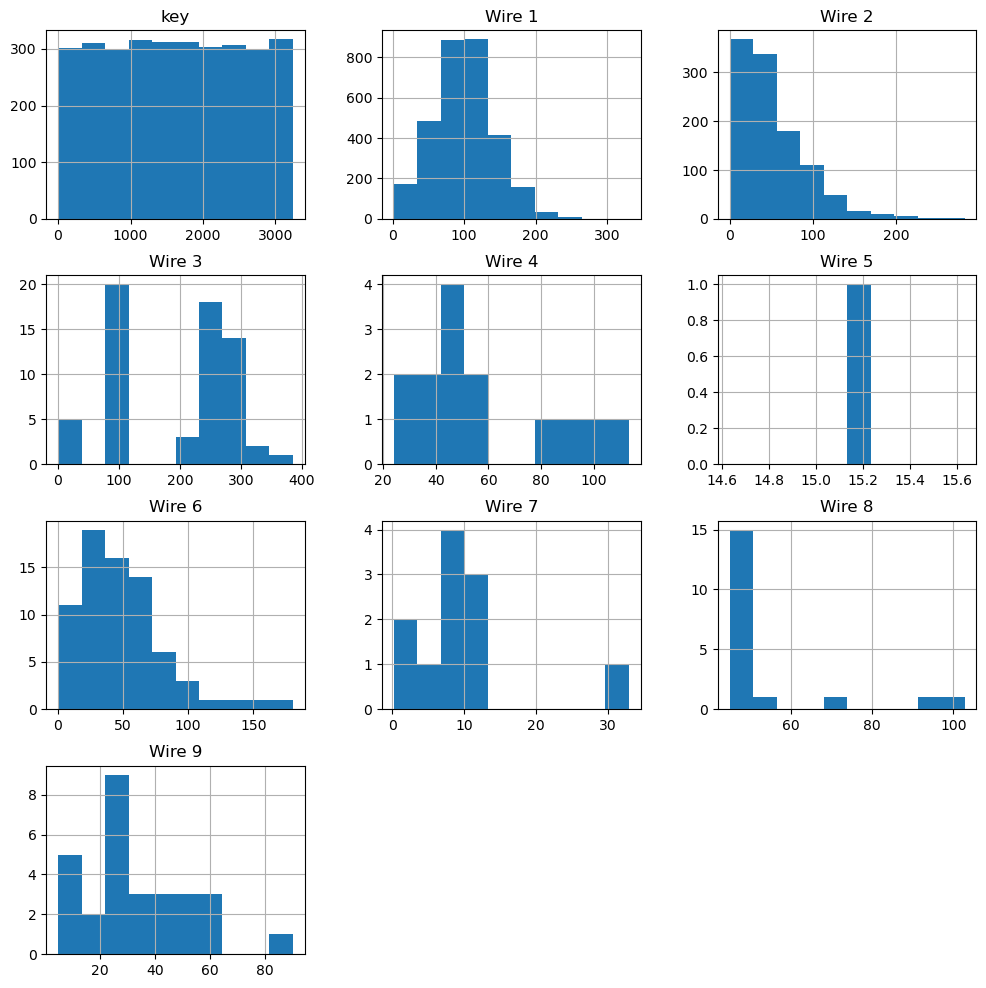

In [21]:
wire.hist(figsize=(12,12))

И снова нам тут особо ничего такого, что могло бы помочь в создании модели, не узнать.

In [22]:
try:
    wire_time = pd.read_csv('/Users/BrightFuture/Desktop/Projects/Final project industry/data/data_wire_time_new.csv')
except FileNotFoundError:
    print('Error: File not found. Please provide the correct file path.')

In [23]:
display(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Я не до конца понимаю технологический процесс влияния проволоки, и не готов сейчас слишком глубоко туда погружаться. На самом деле мне досататочно того, что применений действительно много и того, что я уверен, что мой алгоритм сам посчитает все достаточно точно и отберет наиболее важные параметры. 

Что бы я отметил - так это тот факт, что объектов меньше,чем ключей, так что не для кажого продукта нужна проволока, в отличие от легирующих добавок. 

In [24]:
print(arc[arc['key']==269])
print(temp[temp['key']==269])
print(gas[gas['key']==269])
print(bulk_time[bulk_time['key']==269])
print(wire_time[wire_time['key']==269])

      key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
1223  269  2019-05-13 22:28:51  2019-05-13 22:31:00           0.662361   

      Реактивная мощность  
1223             0.568088  
      key         Время замера  Температура
1489  269  2019-05-13 22:28:41       1612.0
1490  269  2019-05-14 00:48:31       1595.0
     key     Газ 1
266  269  2.255418
Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []
Empty DataFrame
Columns: [key, Wire 1, Wire 2, Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, Wire 9]
Index: []


In [25]:
print(arc[arc['key']==270])
print(temp[temp['key']==270])
print(gas[gas['key']==270])
print(bulk_time[bulk_time['key']==270])
print(wire_time[wire_time['key']==270])

      key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
1224  270  2019-05-14 00:49:41  2019-05-14 00:52:04           0.385572   
1225  270  2019-05-14 00:59:45  2019-05-14 01:01:14           0.414932   
1226  270  2019-05-14 01:04:43  2019-05-14 01:08:54           0.440229   
1227  270  2019-05-14 01:15:42  2019-05-14 01:20:05           0.377613   
1228  270  2019-05-14 01:27:06  2019-05-14 01:29:32           0.853299   
1229  270  2019-05-14 01:32:24  2019-05-14 01:33:29           0.533760   

      Реактивная мощность  
1224             0.270552  
1225             0.298992  
1226             0.332081  
1227             0.236785  
1228             0.577631  
1229             0.344591  
      key         Время замера  Температура
1491  270  2019-05-14 00:49:31       1613.0
1492  270  2019-05-14 00:59:35       1588.0
1493  270  2019-05-14 01:04:33       1586.0
1494  270  2019-05-14 01:15:32       1593.0
1495  270  2019-05-14 01:26:56       1585.0
1496  270  2019-05-14

# Исследовательский анализ данных

Теперь, когда мы посмотрели все таблицы и уже представляем себе структуру данных, можно с ними немного поработать: 

1)Визуализировать данные и/или рассчитать какие-то аггрегированные показатели.

2)Преобразовать, как мы задумывали - вычисления показателей и аггрегированные таблицы, возможно, новые графики

И есть еще одна маленькая, но важная история, которая нам портит не только модель, но и исследовательский анализ данных. Мы уже знаем, что есть один феноменальный выброс в "реактивной мощности" и разобраться с ним надо сразу, пока он не наследил.

In [26]:
print(arc[arc['Реактивная мощность']<0])

       key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924  


А вот и наш выброс. Это даже не выброс, а просто ошибка. Она настолько огромна, что уничтожает все корреляции со столюцом 'Реактивная мощность'

Думаю, никого не обидит, что я удалю эту партию целиком. Хотя в теории я мог бы рассчитать корреляцию между активной и реактивной мощностью, доказать, что она высокая и потом по коэффициенту рассчитать реактивную мощность для этого конкретного подогрева. 

In [27]:
arc = arc.drop(arc[arc['key']==2116].index)

In [28]:
print(arc[arc['Реактивная мощность']<0])

Empty DataFrame
Columns: [key, Начало нагрева дугой, Конец нагрева дугой, Активная мощность, Реактивная мощность]
Index: []


In [29]:
ener = arc[['key','Активная мощность', 'Реактивная мощность']]

In [30]:
print(ener)

        key  Активная мощность  Реактивная мощность
0         1           0.305130             0.211253
1         1           0.765658             0.477438
2         1           0.580313             0.430460
3         1           0.518496             0.379979
4         1           0.867133             0.643691
...     ...                ...                  ...
14871  3241           0.439735             0.299579
14872  3241           0.646498             0.458240
14873  3241           1.039726             0.769302
14874  3241           0.530267             0.361543
14875  3241           0.389057             0.251347

[14872 rows x 3 columns]


In [31]:
ener.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112
std,934.661090,0.258916,0.197623
min,1.000000,0.223120,0.153777
25%,806.000000,0.467114,0.337175
50%,1616.000000,0.599587,0.441667
75%,2429.000000,0.830314,0.608201
max,3241.000000,1.463773,1.270284


In [32]:
print(ener[ener['Реактивная мощность']<0])

Empty DataFrame
Columns: [key, Активная мощность, Реактивная мощность]
Index: []


In [33]:
ener = ener.drop(ener[ener['Реактивная мощность']<0].index)

In [34]:
ener2 = ener.groupby('key')[['Активная мощность', 'Реактивная мощность']].sum()

In [35]:
print(ener2)

      Активная мощность  Реактивная мощность
key                                         
1              3.036730             2.142821
2              2.139408             1.453357
3              4.063641             2.937457
4              2.706489             2.056992
5              2.252950             1.687991
...                 ...                  ...
3237           2.541872             2.025417
3238           1.374821             1.038103
3239           4.848005             3.541541
3240           3.317679             2.373552
3241           3.045283             2.140011

[3213 rows x 2 columns]


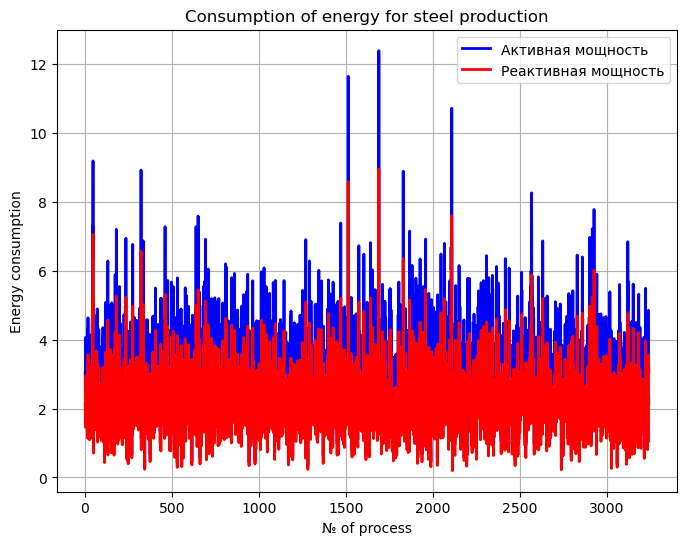

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(ener2.index, ener2['Активная мощность'], color='blue', linewidth=2, label='Активная мощность')
plt.plot(ener2.index, ener2['Реактивная мощность'], color='red', linewidth=2, label='Реактивная мощность')
plt.xlabel('№ of process')
plt.ylabel('Energy consumption')
plt.title('Consumption of energy for steel production')
plt.grid(True)
plt.legend()
plt.show()

Мы видим колебания активной мощности и пока не знаем, чем они вызваны. Я бы проверил корреляцию с затраченным временем на нагрев и с "Газом"

Что-то есть, но если бы газ превращался в электричество, думаю, корреляция была бы значительно ближе к 1. Хотя я только что обнаружил различное количество рядов, придется пересчитать

In [38]:
merged_df = ener2.merge(gas, left_index=True, right_on='key')

In [39]:
print(merged_df['Активная мощность'].corr(merged_df['Газ 1']))

0.3878525933136331


In [40]:
arc2 = arc.copy()

In [41]:
arc2['Начало нагрева дугой'] = pd.to_datetime(arc2['Начало нагрева дугой'])

In [42]:
arc2['Конец нагрева дугой'] = pd.to_datetime(arc2['Конец нагрева дугой'])

In [43]:
arc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 1.2 MB


In [44]:
arc2['time_heated'] = arc2['Конец нагрева дугой']-arc2['Начало нагрева дугой']

In [45]:
arc2['time_heated_sec'] = arc2['time_heated'].dt.total_seconds()

In [46]:
print(arc2)

        key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1         1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2         1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3         1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4         1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
...     ...                  ...                 ...                ...   
14871  3241  2019-09-06 16:49:05 2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11 2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48 2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58 2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54 2019-09-06 17:26:15           0.389057   

       Реактивная мощность     time_heated  time_heated_sec  
0                 0.211253 0 days 00:

In [47]:
print(arc2['Активная мощность'].corr(arc2['time_heated_sec']))

0.010571233477306131


In [48]:
arc2['total_power'] = (arc2['Активная мощность']**2 + arc2['Реактивная мощность']**2)**0.5

In [49]:
print(arc2['total_power'].corr(arc2['time_heated_sec']))

0.009192339730051817


In [50]:
print(arc2['Активная мощность'].corr(arc2['Реактивная мощность']))

0.9663821708188466


Поскольку корреляции между мощностью и временем отсутствует, можно сделать вывод, что мощность представляет расход энергии в единицу времени. Заначит, нам придется считать производный показатель и здесь. Хорошо, что теперь мы это знаем. 

В выводе хочется отметить, что мы двольно детально изучили данные и теперь полностью понимаем как двигаться дальше и готовы к этому. 

Дальнейший план работы:

1) Доделать предобработку данных. Убрать все данные, которые не подходят для целей нашего прогнозирования.

2) Создание дополнительных параметров. У меня ощущение, что того, что у нас есть на данный момент будет недостаточно. 

3) Агрегирование всех данных в общую таблицу для созадния модели машинного обучения.

4) Создание 3 моделей машинного обучения. Предварительно планируются модель регрессии, модель случайного леса и модель градитентного бустина XGboost, но если в какой-то момент появится желание создать любую другую модель, я не буду отказывать себе в удовольствии. (пока не забыл - я бы попробовал различные виды регуляризации в регрессии, чтобы проверить мое предположение о чрезмерном влиянии энергии затраченной на подогрев на температуру и попробовать выявить и другие важные факторы)

5) Выбор лучшей модели по показателю MAE на кросс-валидации. Тестирование модели и вывод.

# Предобработка данных

## Время нагревания

In [54]:
arc2['total_energy'] = arc2['total_power'] * arc2['time_heated_sec']

In [55]:
arc_attn = arc2[['key', 'time_heated_sec', 'total_power', 'total_energy']]

In [56]:
arc_grouped = arc_attn.groupby('key')[['time_heated_sec', 'total_power', 'total_energy']].sum()

In [57]:
print(arc_grouped)

      time_heated_sec  total_power  total_energy
key                                             
1              1098.0     3.718736    770.282114
2               811.0     2.588349    481.760005
3               655.0     5.019223    722.837668
4               741.0     3.400038    683.455597
5               869.0     2.816980    512.169934
...               ...          ...           ...
3237            909.0     3.250657    630.503534
3238            546.0     1.723937    286.052252
3239           1216.0     6.014480    941.538764
3240            839.0     4.082920    657.439848
3241            659.0     3.722880    538.258300

[3213 rows x 3 columns]


Вот так, я думаю, должна выглядеть финальная таблица признаков, которые можно получить из их информации о нагревании стали.

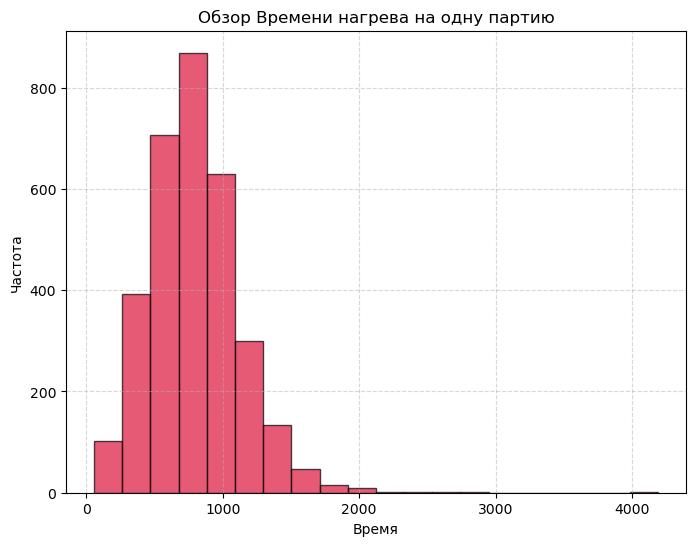

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(arc_grouped['time_heated_sec'], bins=20, color='crimson', edgecolor='black', alpha=0.7)

plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Обзор Времени нагрева на одну партию')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [59]:
arc_grouped['time_heated_sec'].describe()

count    3213.000000
mean      794.691566
std       332.439136
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: time_heated_sec, dtype: float64

In [60]:
start_times = arc2.groupby('key')['Начало нагрева дугой'].first()
end_times = arc2.groupby('key')['Конец нагрева дугой'].last()
arc_times = pd.concat([start_times, end_times], axis=1)
print(arc_times)

     Начало нагрева дугой Конец нагрева дугой
key                                          
1     2019-05-03 11:02:14 2019-05-03 11:28:37
2     2019-05-03 11:34:14 2019-05-03 11:53:18
3     2019-05-03 12:06:54 2019-05-03 12:32:19
4     2019-05-03 12:39:37 2019-05-03 12:57:50
5     2019-05-03 13:11:13 2019-05-03 13:33:55
...                   ...                 ...
3237  2019-09-06 11:31:25 2019-09-06 11:53:55
3238  2019-09-06 12:16:25 2019-09-06 12:31:35
3239  2019-09-06 14:17:00 2019-09-06 15:05:50
3240  2019-09-06 15:25:31 2019-09-06 16:24:15
3241  2019-09-06 16:49:05 2019-09-06 17:26:15

[3213 rows x 2 columns]


In [61]:
print(arc_times.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Начало нагрева дугой  3213 non-null   datetime64[ns]
 1   Конец нагрева дугой   3213 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 75.3 KB
None


## Замеры температуры

In [62]:
display(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [63]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [64]:
temp_nuns = temp[temp['Температура'].isna()]
print(temp_nuns['key'].unique())

[2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513
 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527
 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541
 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555
 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569
 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581 2582 2583
 2584 2585 2586 2587 2588 2589 2590 2591 2592 2593 2594 2595 2596 2597
 2598 2599 2600 2601 2602 2603 2604 2605 2606 2607 2608 2609 2610 2611
 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621 2622 2623 2624 2625
 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638 2639
 2640 2641 2642 2643 2644 2645 2646 2647 2648 2649 2650 2651 2652 2653
 2654 2655 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666 2667
 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677 2678 2679 2680 2681
 2682 2684 2685 2686 2687 2688 2689 2690 2691 2692 2693 2694 2695 2696
 2697 

А нулей у нас тут много... по сути все ключи после 2499 без температуры. Но странно, что общая доля всех пропусков 23%, а общая доля уникальных значений 30%.

In [65]:
exp = temp[temp['key'].isin(temp_nuns['key'].unique())]
print(exp.head(30))

        key         Время замера  Температура
13926  2500  2019-08-10 14:04:39       1539.0
13927  2500  2019-08-10 14:13:11          NaN
13928  2500  2019-08-10 14:18:12          NaN
13929  2500  2019-08-10 14:25:53          NaN
13930  2500  2019-08-10 14:29:39          NaN
13931  2501  2019-08-10 14:41:14       1587.0
13932  2501  2019-08-10 14:49:15          NaN
13933  2501  2019-08-10 15:02:56          NaN
13934  2501  2019-08-10 15:07:47          NaN
13935  2501  2019-08-10 15:16:53          NaN
13936  2501  2019-08-10 15:22:50          NaN
13937  2501  2019-08-10 15:29:00          NaN
13938  2502  2019-08-10 15:39:39       1583.0
13939  2502  2019-08-10 15:47:31          NaN
13940  2502  2019-08-10 15:53:16          NaN
13941  2502  2019-08-10 15:59:29          NaN
13942  2502  2019-08-10 16:04:55          NaN
13943  2503  2019-08-10 16:27:44       1603.0
13944  2503  2019-08-10 16:38:49          NaN
13945  2503  2019-08-10 16:51:14          NaN
13946  2503  2019-08-10 17:03:21  

In [66]:
counts = exp.groupby('key')['Температура'].count().sort_values(ascending=False)
print(counts)

key
2500    1
2997    1
2988    1
2989    1
2990    1
       ..
2749    1
2750    1
2751    1
2752    1
3241    1
Name: Температура, Length: 739, dtype: int64


Теперь все стало на свои места. У всех партий, начиная с 2500 есть только одна температура - и это стартовая темпаратура. Идеально было бы, если бы нам дали ее в конце, чтобы мы протестировали данные. А то бить 2499 партий на 3 выборки это больно.

Оказалось, это неизбежно и новых данных не предвидится. Так что пока держим в уме, что все данные партии, которые придется исключить из-за отсутствия целевой температуры, находятся  в temp_nuns['key'].unique()

In [67]:
start_temp = temp.groupby('key')['Температура'].first()
end_temp = temp.groupby('key')['Температура'].last()
temperatures = pd.concat([start_temp, end_temp], axis=1)
temperatures.columns = ['start_temp', 'end_temp']
print(temperatures)

      start_temp  end_temp
key                       
1         1571.0    1613.0
2         1581.0    1602.0
3         1596.0    1599.0
4         1601.0    1625.0
5         1576.0    1602.0
...          ...       ...
3237      1569.0    1569.0
3238      1584.0    1584.0
3239      1598.0    1598.0
3240      1617.0    1617.0
3241      1586.0    1586.0

[3216 rows x 2 columns]


Вот в таком виде нам нужны данные для нашей модели.Начальная температура - это важный параметр, а конечная температура - целевой показатель. Осталось только убрать объекты с отсутсвтвующим целевым показателем.

Таблицы gas, bulk и wire мы оставим как есть, поскольку они уже представляют собой признаки. 

таблицы bulk_time и wire_time мы пока трогать не будем. В теории они нужны, чтобы проверить данные на валидность, однако на данный момент я не буду этим заниматься по 2 причинам:

1) я хочу сначала посторить хотя бы одну модель и проверить, насколько у нас все плохо или хорошо, чтобы оценить наши данные. 

2) я не представляю, как автоматизировать этот процесс. Пока что у меня есть идея только сделать общую таблицу (из arc, bulk_time и wire_timeб temp) и отсортировать ее по таймлану. Но вот как найти ошибки - это уже вопрос. Снова сказываются 50 часов, потраченные на SQl... там есть функция SELECT ROW_NUMBER() OVER () и при помощи нее я бы проранжировал все операции в рамках одной партии (ключа) Но потом бы пришлось еще каким-то образом выяснить, где есть какие-то операции, сделанные позже, чем финальная температура, а вот тут у меня пока идей нет. Буду признательным за подсказку, если эта часть обязательная.


## Время между замерами

Для начала я хочу попробовать создать и проанализировать дополнительный параметр - время между первым и последним замерами температуры. Есть идея (которая принесла нам прмерно 0.2 MAE), что партии обрабатываются с разной скоростью, а некоторые партии вообще простаивают по причнам пересменок, перерывов и т.д.

И если немного развить идею, получится, что чем дольше время между первым и последним замерами, тем больше сталь успеет остыть.

In [68]:
start_temp_time = temp.groupby('key')['Время замера'].first()
end_temp_time = temp.groupby('key')['Время замера'].last()
temperatures_time = pd.concat([start_temp_time, end_temp_time], axis=1)
temperatures_time.columns = ['first_measure', 'last_measure']
print(temperatures_time)

            first_measure         last_measure
key                                           
1     2019-05-03 11:02:04  2019-05-03 11:30:38
2     2019-05-03 11:34:04  2019-05-03 11:55:09
3     2019-05-03 12:06:44  2019-05-03 12:35:57
4     2019-05-03 12:39:27  2019-05-03 12:59:47
5     2019-05-03 13:11:03  2019-05-03 13:36:39
...                   ...                  ...
3237  2019-09-06 11:31:15  2019-09-06 11:55:45
3238  2019-09-06 12:16:15  2019-09-06 12:34:37
3239  2019-09-06 14:16:50  2019-09-06 15:09:55
3240  2019-09-06 15:25:21  2019-09-06 16:35:26
3241  2019-09-06 16:48:55  2019-09-06 17:30:05

[3216 rows x 2 columns]


In [69]:
temperatures_time['first_measure'] = pd.to_datetime(temperatures_time['first_measure'])
temperatures_time['last_measure'] = pd.to_datetime(temperatures_time['last_measure'])

In [70]:
temperatures_time['total_time'] = temperatures_time['last_measure'] - temperatures_time['first_measure']
temperatures_time['total_time'] = temperatures_time['total_time'].dt.total_seconds()

In [71]:
print(temperatures_time)

           first_measure        last_measure  total_time
key                                                     
1    2019-05-03 11:02:04 2019-05-03 11:30:38      1714.0
2    2019-05-03 11:34:04 2019-05-03 11:55:09      1265.0
3    2019-05-03 12:06:44 2019-05-03 12:35:57      1753.0
4    2019-05-03 12:39:27 2019-05-03 12:59:47      1220.0
5    2019-05-03 13:11:03 2019-05-03 13:36:39      1536.0
...                  ...                 ...         ...
3237 2019-09-06 11:31:15 2019-09-06 11:55:45      1470.0
3238 2019-09-06 12:16:15 2019-09-06 12:34:37      1102.0
3239 2019-09-06 14:16:50 2019-09-06 15:09:55      3185.0
3240 2019-09-06 15:25:21 2019-09-06 16:35:26      4205.0
3241 2019-09-06 16:48:55 2019-09-06 17:30:05      2470.0

[3216 rows x 3 columns]


In [72]:
temperatures_time = temperatures_time.drop(['first_measure', 'last_measure'], axis=1)

In [73]:
print(temperatures_time)

      total_time
key             
1         1714.0
2         1265.0
3         1753.0
4         1220.0
5         1536.0
...          ...
3237      1470.0
3238      1102.0
3239      3185.0
3240      4205.0
3241      2470.0

[3216 rows x 1 columns]


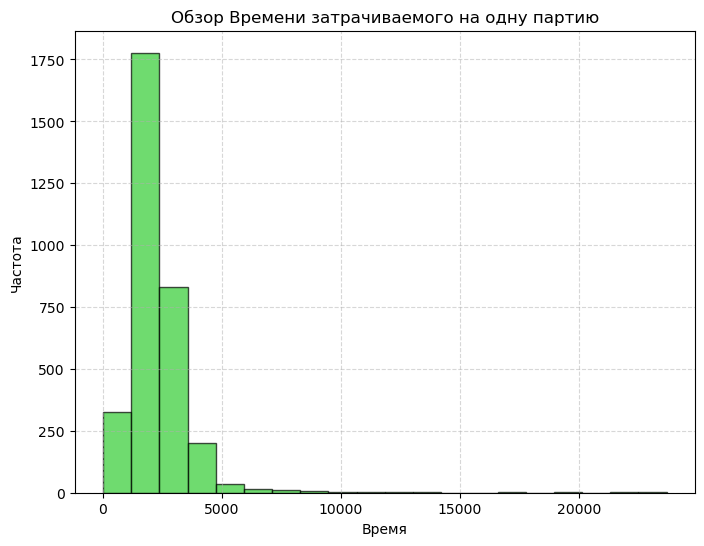

In [74]:
plt.figure(figsize=(8, 6))
plt.hist(temperatures_time, bins=20, color='limegreen', edgecolor='black', alpha=0.7)

plt.xlabel('Время')
plt.ylabel('Частота')
plt.title('Обзор Времени затрачиваемого на одну партию')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Ну вот и получается, что среднее время нагревания у нас около 1000 секунд (15 мин), среднее время производтва около 2000 секунд (30 мин), при этом есть продукты, которые 6 часов "в производтве" а по факту, навернякак ночуют... Да и трехчасовые тоже присутствуют. В общем, параметр сильный, не зря он нам так сильно снизил MAE.

Прикол в том, что  хоть показателей температуры и нет в таблице, время замеров есть. Нам это не помешает, потму что у нас невалидные данные сами отсеятся при слиянии таблиц но сам факт, конечно смешной.

И добавлю, что в идеале я бы поубирал все эти загулы, но у нас тогда, наверное, вообще очень мало данных останется. 

# Дообработка данных

## Температура плавления

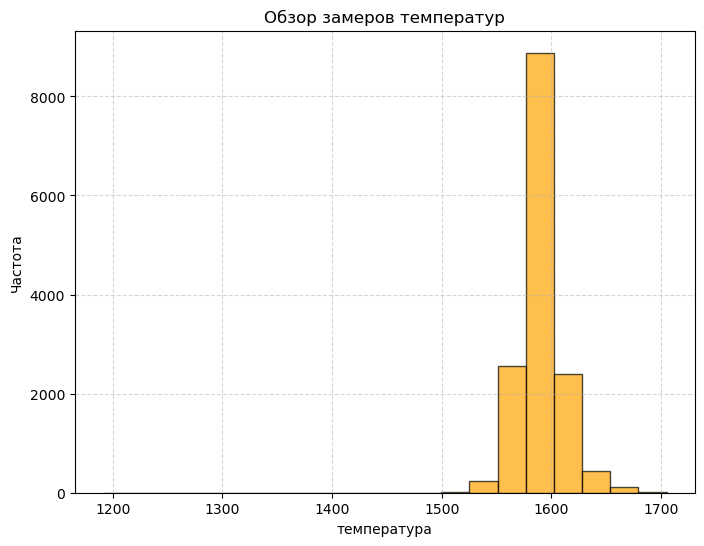

In [75]:
plt.figure(figsize=(8, 6))
plt.hist(temp['Температура'], bins=20, color='orange', edgecolor='black', alpha=0.7)

plt.xlabel('температура')
plt.ylabel('Частота')
plt.title('Обзор замеров температур')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Видимо, у нас есть выбросы и они довольно серьезные. Хочу отметить, что температура плавления стали начинается от 1350 градусов и это для самых легковыплавляемых сплавов. Значит, все замеры/партии, где температура ниже этой границы - выбросы. 

In [76]:
print(temp[temp['Температура']<1350])

        key         Время замера  Температура
4883    867  2019-06-06 08:03:39       1191.0
6784   1214  2019-06-18 08:01:03       1208.0
9050   1619  2019-07-03 02:34:41       1218.0
11495  2052  2019-07-25 08:49:15       1227.0
14283  2561  2019-08-12 18:49:29       1204.0


In [77]:
print(temp[temp['key'].isin([867, 1214,1619, 2052, 2561])])

        key         Время замера  Температура
4883    867  2019-06-06 08:03:39       1191.0
4884    867  2019-06-06 08:18:52       1575.0
4885    867  2019-06-06 08:22:38       1576.0
4886    867  2019-06-06 08:25:11       1571.0
4887    867  2019-06-06 08:29:49       1600.0
4888    867  2019-06-06 08:36:49       1522.0
4889    867  2019-06-06 08:43:02       1521.0
4890    867  2019-06-06 08:48:23       1599.0
6784   1214  2019-06-18 08:01:03       1208.0
6785   1214  2019-06-18 08:17:56       1608.0
6786   1214  2019-06-18 08:31:10       1608.0
6787   1214  2019-06-18 08:43:56       1591.0
9050   1619  2019-07-03 02:34:41       1218.0
9051   1619  2019-07-03 02:39:29       1623.0
9052   1619  2019-07-03 02:43:59       1590.0
11495  2052  2019-07-25 08:49:15       1227.0
11496  2052  2019-07-25 08:54:39       1592.0
11497  2052  2019-07-25 09:03:59       1590.0
11498  2052  2019-07-25 09:07:19       1591.0
11499  2052  2019-07-25 09:20:11       1515.0
11500  2052  2019-07-25 09:27:03  

In [78]:
print(arc[arc['key']==867])

      key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
4028  867  2019-06-06 08:03:49  2019-06-06 08:06:04           1.362161   
4029  867  2019-06-06 08:19:02  2019-06-06 08:21:37           0.520198   
4030  867  2019-06-06 08:22:48  2019-06-06 08:23:47           0.558775   
4031  867  2019-06-06 08:25:21  2019-06-06 08:27:11           0.525132   
4032  867  2019-06-06 08:29:59  2019-06-06 08:33:08           0.661064   
4033  867  2019-06-06 08:36:59  2019-06-06 08:41:13           0.365236   
4034  867  2019-06-06 08:43:12  2019-06-06 08:44:19           0.852855   

      Реактивная мощность  
4028             0.948663  
4029             0.391826  
4030             0.361147  
4031             0.411021  
4032             0.578344  
4033             0.292677  
4034             0.620585  


Да, полный бред. Даже если бы я в теории поверил, что в ковш засыпали какие-нибуль металические штуки, чтобы расплавить, что противоречит описанию технологического процесса, невозможно за 3 минутки 100 тонн металла расплавить и нагреть на 400 градусов. 

Поздравляю, мы нашли еще немного лютых выбросов. 

In [79]:
invalid_keys = [867, 1214,1619, 2052, 2561]

И температура плавления приносит грифиндору 0.2 градуса на валидационной выборке и 0.6 градуса на тестовой выборке.

## Время остывания

In [80]:
check_tab= temperatures.merge(arc_grouped, left_index=True, right_index=True)

In [81]:
check_tab = check_tab.merge(temperatures_time, left_index=True, right_index=True)

In [82]:
display(check_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,total_time
key,,,,,,
1,1571.0,1613.0,1098.0,3.718736,770.282114,1714.0
2,1581.0,1602.0,811.0,2.588349,481.760005,1265.0
3,1596.0,1599.0,655.0,5.019223,722.837668,1753.0
4,1601.0,1625.0,741.0,3.400038,683.455597,1220.0
5,1576.0,1602.0,869.0,2.816980,512.169934,1536.0
...,...,...,...,...,...,...
3237,1569.0,1569.0,909.0,3.250657,630.503534,1470.0
3238,1584.0,1584.0,546.0,1.723937,286.052252,1102.0
3239,1598.0,1598.0,1216.0,6.014480,941.538764,3185.0


Как насчет того, чтобы найти коэфициент, насколько общее время обрабоки (по факту от начального замера до конечного) дольше, чем время нагревания. И на этом пространстве мы тоже найдем выбросы. 

In [83]:
check_tab['prod_heat_rate'] = check_tab['total_time']/check_tab['time_heated_sec']

In [84]:
display(check_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,total_time,prod_heat_rate
key,,,,,,,
1,1571.0,1613.0,1098.0,3.718736,770.282114,1714.0,1.561020
2,1581.0,1602.0,811.0,2.588349,481.760005,1265.0,1.559803
3,1596.0,1599.0,655.0,5.019223,722.837668,1753.0,2.676336
4,1601.0,1625.0,741.0,3.400038,683.455597,1220.0,1.646424
5,1576.0,1602.0,869.0,2.816980,512.169934,1536.0,1.767549
...,...,...,...,...,...,...,...
3237,1569.0,1569.0,909.0,3.250657,630.503534,1470.0,1.617162
3238,1584.0,1584.0,546.0,1.723937,286.052252,1102.0,2.018315
3239,1598.0,1598.0,1216.0,6.014480,941.538764,3185.0,2.619243


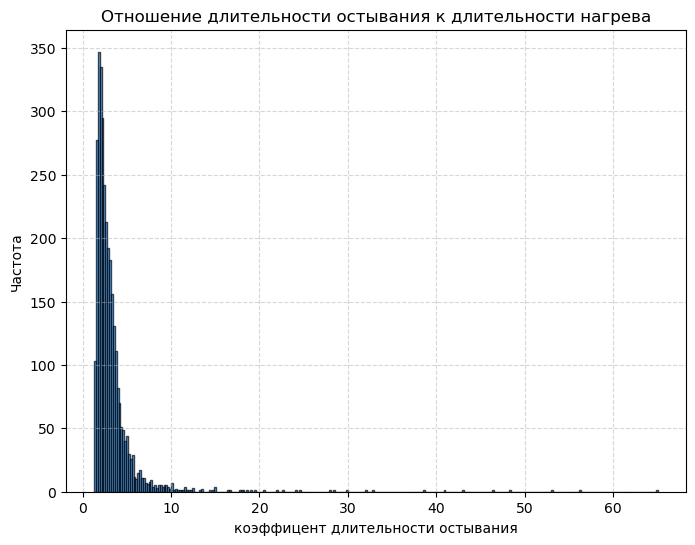

In [85]:
plt.figure(figsize=(8, 6))
plt.hist(check_tab['prod_heat_rate'], bins=300, color='dodgerblue', edgecolor='black', alpha=0.7)

plt.xlabel('коэффицент длительности остывания')
plt.ylabel('Частота')
plt.title('Отношение длительности остывания к длительности нагрева')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Ничего такого, чего мы не ожидали. А почему ожидали? - да потому, что знали про пересменки и ночевки... Вопрос в другом, как нам лучше определить границу, после которой данные будут считаться выбросами. Если честно, я бы воспользовался правилом 3 сигм, чтобы опираться на какую-нибудь статистику, нежели на "экспертное мнение"

Но если подумать, то это немного неправильно. У нас тут распределение со скосом вправо, а в таких распределениях находятся несколько иначе. Предлагаю воспользоваться межквартальным размахом. 

IQR = Q3-Q1

Верхняя граница выбросов = Q3 + 3 * IQR

In [86]:
print(check_tab['prod_heat_rate'].describe())

count    3213.000000
mean        3.263305
std         3.232889
min         1.298013
25%         1.987030
50%         2.578732
75%         3.538012
max        65.038760
Name: prod_heat_rate, dtype: float64


In [87]:
q1 = 1.987030
q3 = 3.538012

In [88]:
iqr = q3 - q1

In [89]:
limit = q3 + 3*iqr
print(limit)

8.190958


так-то это уж как-то совсем мало и значительно меньше, чем мне казалось, вручную я бы ни за что меньше 10 не поставил. С другой стороны кто я такой, чтобы спорить со статистикой (я и так увеличил кэф IQR с 1,5 до 3, что, конечно, же допустимо), так что раз уже решил делать по уму, то так тому и быть. 

In [90]:
print(check_tab[check_tab['prod_heat_rate']>limit])

      start_temp  end_temp  time_heated_sec  total_power  total_energy  \
key                                                                      
19        1625.0    1597.0            321.0     2.894804    313.650413   
49        1626.0    1588.0            126.0     1.220071    153.728952   
112       1594.0    1582.0             95.0     0.766908     72.856258   
114       1631.0    1600.0            519.0     1.681273    279.085512   
115       1635.0    1547.0            725.0     5.195004    691.681431   
...          ...       ...              ...          ...           ...   
3059      1599.0    1599.0            138.0     0.480107     66.254708   
3112      1651.0    1651.0            124.0     0.671299     83.241067   
3113      1624.0    1624.0            299.0     1.100931    163.740088   
3120      1578.0    1578.0           1142.0     8.333317   1081.146525   
3150      1625.0    1625.0            320.0     2.194414    277.390796   

      total_time  prod_heat_rate  
ke

еще 95 выбросов. Часть из них, конечно, придестя на уже отброшенные значения. Но вообще интересно, что же у нас останется. В результате самых элементарных преобразований оставалось 2324, вроде

In [91]:
invalids2 = check_tab[check_tab['prod_heat_rate']>limit].copy()

In [92]:
invalid_keys2 = invalids2.index

In [93]:
print(invalid_keys2)

Int64Index([  19,   49,  112,  114,  115,  119,  167,  196,  220,  221,  246,
             247,  248,  249,  269,  323,  343,  530,  536,  556,  614,  641,
             661,  732,  782,  801,  943,  977, 1048, 1081, 1232, 1268, 1276,
            1281, 1288, 1369, 1449, 1457, 1479, 1514, 1535, 1543, 1547, 1568,
            1601, 1615, 1729, 1766, 1774, 1911, 1914, 1937, 1958, 1974, 1982,
            1986, 1988, 1995, 2006, 2032, 2050, 2107, 2109, 2110, 2112, 2163,
            2179, 2194, 2221, 2250, 2361, 2408, 2434, 2468, 2472, 2528, 2537,
            2566, 2568, 2582, 2699, 2738, 2739, 2795, 2796, 2821, 2822, 2841,
            2856, 3026, 3059, 3112, 3113, 3120, 3150],
           dtype='int64', name='key')


 # Создание агрегированной таблицы признаков

In [94]:
final_tab = temperatures[~temperatures.index.isin(temp_nuns['key'])].copy()

In [95]:
final_tab = final_tab[~final_tab.index.isin(invalid_keys)]

In [96]:
final_tab = final_tab[~final_tab.index.isin(invalid_keys2)]

In [97]:
print(final_tab)

      start_temp  end_temp
key                       
1         1571.0    1613.0
2         1581.0    1602.0
3         1596.0    1599.0
4         1601.0    1625.0
5         1576.0    1602.0
...          ...       ...
2495      1570.0    1591.0
2496      1554.0    1591.0
2497      1571.0    1589.0
2498      1591.0    1594.0
2499      1569.0    1603.0

[2398 rows x 2 columns]


In [98]:
try:
    print(final_tab.loc[867])
except KeyError:
    print("нет такого ключа")

нет такого ключа


In [99]:
final_tab = final_tab.merge(arc_grouped, left_index=True, right_index=True)

In [100]:
print(final_tab)

      start_temp  end_temp  time_heated_sec  total_power  total_energy
key                                                                   
1         1571.0    1613.0           1098.0     3.718736    770.282114
2         1581.0    1602.0            811.0     2.588349    481.760005
3         1596.0    1599.0            655.0     5.019223    722.837668
4         1601.0    1625.0            741.0     3.400038    683.455597
5         1576.0    1602.0            869.0     2.816980    512.169934
...          ...       ...              ...          ...           ...
2495      1570.0    1591.0            723.0     3.868721    694.177326
2496      1554.0    1591.0            940.0     5.070316    815.818538
2497      1571.0    1589.0            569.0     4.360918    823.020520
2498      1591.0    1594.0            750.0     3.909917    581.810739
2499      1569.0    1603.0            883.0     2.169252    532.386183

[2395 rows x 5 columns]


In [101]:
final_tab = final_tab.merge(gas, left_index=True, right_on='key')

In [102]:
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,key,Газ 1
0,1571.0,1613.0,1098.0,3.718736,770.282114,1,29.749986
1,1581.0,1602.0,811.0,2.588349,481.760005,2,12.555561
2,1596.0,1599.0,655.0,5.019223,722.837668,3,28.554793
3,1601.0,1625.0,741.0,3.400038,683.455597,4,18.841219
4,1576.0,1602.0,869.0,2.816980,512.169934,5,5.413692
...,...,...,...,...,...,...,...
2492,1570.0,1591.0,723.0,3.868721,694.177326,2495,7.125735
2493,1554.0,1591.0,940.0,5.070316,815.818538,2496,9.412616
2494,1571.0,1589.0,569.0,4.360918,823.020520,2497,6.271699
2495,1591.0,1594.0,750.0,3.909917,581.810739,2498,14.953657


Вот тут у нас случился интересный момент, который хочу отметить (поскольку пришлось фиксить) - с последнем мерджем у нас дропнулись индексы и теперь мы уже объединяем все таблицы по колонке 'key'

In [103]:
final_tab = final_tab.merge(bulk, left_on='key', right_on='key')

In [104]:
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,key,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1571.0,1613.0,1098.0,3.718736,770.282114,1,29.749986,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,1581.0,1602.0,811.0,2.588349,481.760005,2,12.555561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,1596.0,1599.0,655.0,5.019223,722.837668,3,28.554793,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,1601.0,1625.0,741.0,3.400038,683.455597,4,18.841219,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,1576.0,1602.0,869.0,2.816980,512.169934,5,5.413692,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,1570.0,1591.0,723.0,3.868721,694.177326,2495,7.125735,NaN,NaN,21.0,...,NaN,NaN,NaN,NaN,90.0,NaN,256.0,NaN,129.0,223.0
2331,1554.0,1591.0,940.0,5.070316,815.818538,2496,9.412616,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0
2332,1571.0,1589.0,569.0,4.360918,823.020520,2497,6.271699,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0
2333,1591.0,1594.0,750.0,3.909917,581.810739,2498,14.953657,NaN,NaN,90.0,...,NaN,NaN,NaN,NaN,101.0,NaN,206.0,NaN,129.0,207.0


In [105]:
final_tab = final_tab.merge(wire, left_on='key', right_on='key')

In [106]:
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,key,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,1098.0,3.718736,770.282114,1,29.749986,NaN,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1581.0,1602.0,811.0,2.588349,481.760005,2,12.555561,NaN,NaN,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1596.0,1599.0,655.0,5.019223,722.837668,3,28.554793,NaN,NaN,NaN,...,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1601.0,1625.0,741.0,3.400038,683.455597,4,18.841219,NaN,NaN,NaN,...,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1576.0,1602.0,869.0,2.816980,512.169934,5,5.413692,NaN,NaN,NaN,...,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,1570.0,1591.0,723.0,3.868721,694.177326,2495,7.125735,NaN,NaN,21.0,...,223.0,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2255,1554.0,1591.0,940.0,5.070316,815.818538,2496,9.412616,NaN,NaN,NaN,...,226.0,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2256,1571.0,1589.0,569.0,4.360918,823.020520,2497,6.271699,NaN,NaN,NaN,...,226.0,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2257,1591.0,1594.0,750.0,3.909917,581.810739,2498,14.953657,NaN,NaN,90.0,...,207.0,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
final_tab = final_tab.merge(temperatures_time, left_on='key', right_index=True)
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,key,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,total_time
0,1571.0,1613.0,1098.0,3.718736,770.282114,1,29.749986,NaN,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1714.0
1,1581.0,1602.0,811.0,2.588349,481.760005,2,12.555561,NaN,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1265.0
2,1596.0,1599.0,655.0,5.019223,722.837668,3,28.554793,NaN,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1753.0
3,1601.0,1625.0,741.0,3.400038,683.455597,4,18.841219,NaN,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0
4,1576.0,1602.0,869.0,2.816980,512.169934,5,5.413692,NaN,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,1570.0,1591.0,723.0,3.868721,694.177326,2495,7.125735,NaN,NaN,21.0,...,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1380.0
2255,1554.0,1591.0,940.0,5.070316,815.818538,2496,9.412616,NaN,NaN,NaN,...,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1705.0
2256,1571.0,1589.0,569.0,4.360918,823.020520,2497,6.271699,NaN,NaN,NaN,...,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,962.0
2257,1591.0,1594.0,750.0,3.909917,581.810739,2498,14.953657,NaN,NaN,90.0,...,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.0


In [108]:
final_tab.set_index('key', inplace=True)

In [109]:
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,total_time
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1098.0,3.718736,770.282114,29.749986,NaN,NaN,NaN,43.0,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1714.0
2,1581.0,1602.0,811.0,2.588349,481.760005,12.555561,NaN,NaN,NaN,73.0,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1265.0
3,1596.0,1599.0,655.0,5.019223,722.837668,28.554793,NaN,NaN,NaN,34.0,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1753.0
4,1601.0,1625.0,741.0,3.400038,683.455597,18.841219,NaN,NaN,NaN,81.0,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0
5,1576.0,1602.0,869.0,2.816980,512.169934,5.413692,NaN,NaN,NaN,78.0,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,723.0,3.868721,694.177326,7.125735,NaN,NaN,21.0,NaN,...,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1380.0
2496,1554.0,1591.0,940.0,5.070316,815.818538,9.412616,NaN,NaN,NaN,63.0,...,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1705.0
2497,1571.0,1589.0,569.0,4.360918,823.020520,6.271699,NaN,NaN,NaN,85.0,...,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,962.0


In [110]:
final_tab['cooling_time'] = final_tab['total_time'] - final_tab['time_heated_sec']
final_tab = final_tab.drop('total_time', axis=1)

In [111]:
final_tab.fillna(0, inplace=True)

In [112]:
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,cooling_time
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1098.0,3.718736,770.282114,29.749986,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,616.0
2,1581.0,1602.0,811.0,2.588349,481.760005,12.555561,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,454.0
3,1596.0,1599.0,655.0,5.019223,722.837668,28.554793,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1098.0
4,1601.0,1625.0,741.0,3.400038,683.455597,18.841219,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,479.0
5,1576.0,1602.0,869.0,2.816980,512.169934,5.413692,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,723.0,3.868721,694.177326,7.125735,0.0,0.0,21.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0
2496,1554.0,1591.0,940.0,5.070316,815.818538,9.412616,0.0,0.0,0.0,63.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,765.0
2497,1571.0,1589.0,569.0,4.360918,823.020520,6.271699,0.0,0.0,0.0,85.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393.0


У нас получилась отличная, на мой взгляд, таблица признаков, давайте же скорее посмотрим, как модель сможет по нашим признакам рассчитать температуру.

In [113]:
correlation_matrix = final_tab.corr()

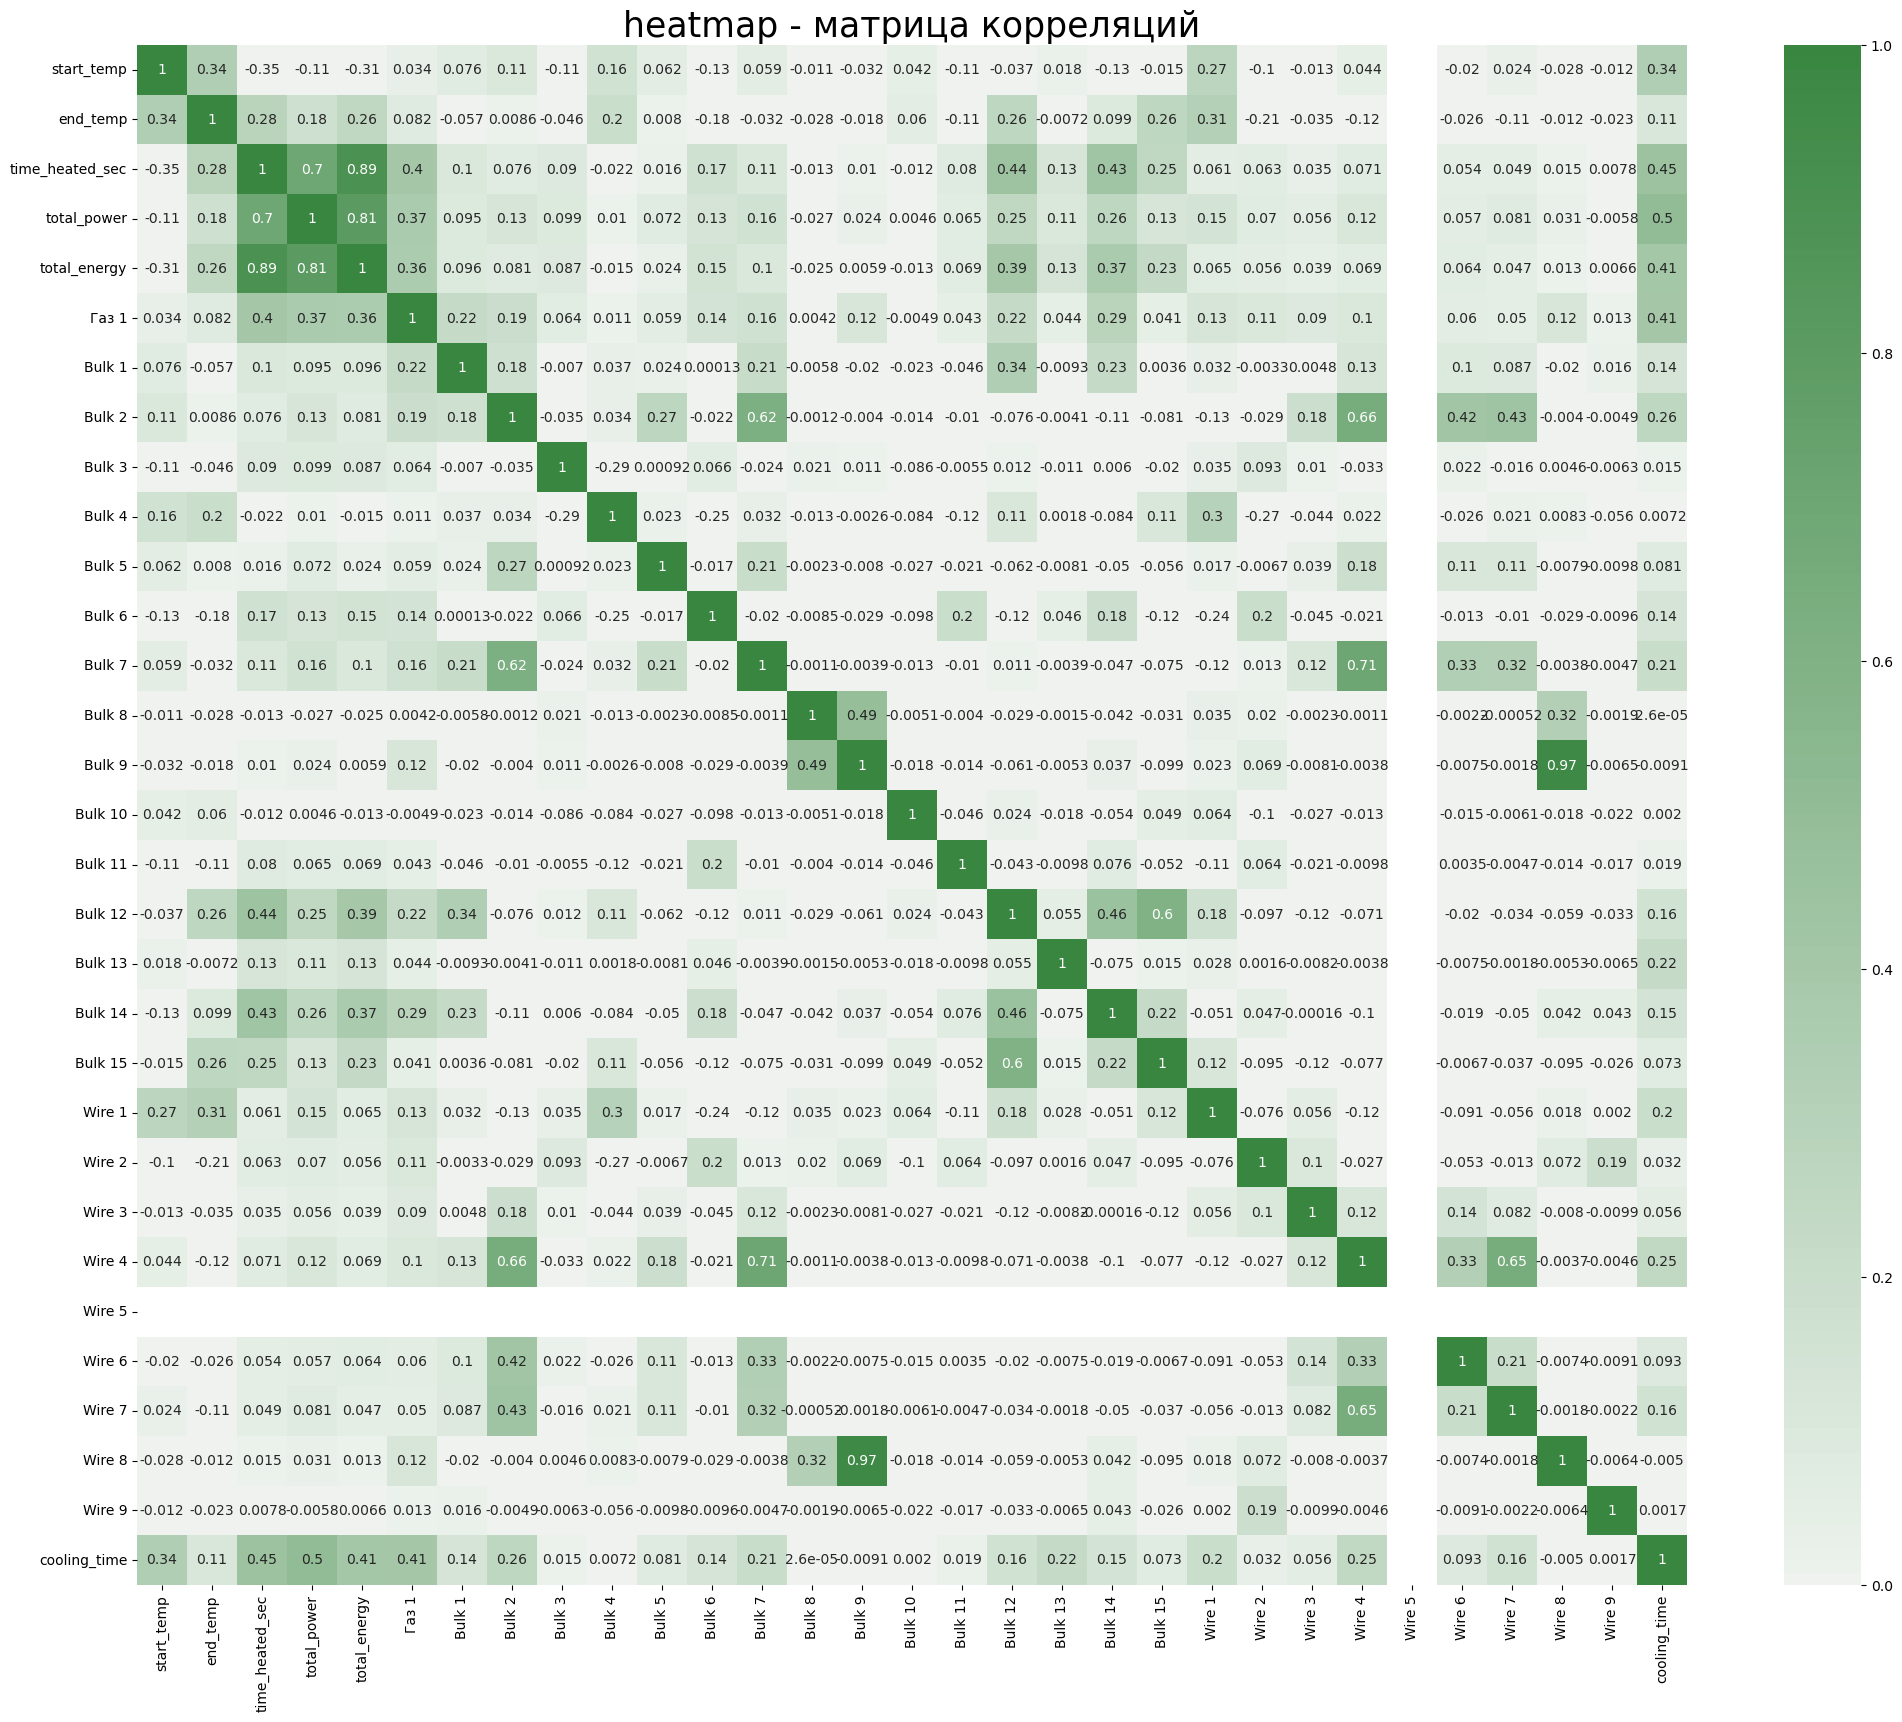

In [ ]:
f, ax = plt.subplots(figsize=(25, 20))
cmap = sns.diverging_palette(170, 130, as_cmap=True)
ax = sns.heatmap(correlation_matrix, cmap=cmap, annot=True, vmax=1, vmin=0, center=0, linewidths=0, xticklabels=True, yticklabels=True)
plt.title('heatmap - матрица корреляций', fontsize=25)
plt.show()


Если изучить кореляцию  между признаками, у нас есть 3 очень сильно коррелирующих параметра: время нагрева, общая мощность, всего энергозатраты. Оно и понятно, поскольку энергозатраты = время * мощность. Тем не менее все корреляции внутри нашей итоговой таблицы меньше 0.9, поэтому удалять мы ничего не будем. 

В каком-то смысле у нас есть мультиколинеарность Шредингера - в зависимости от того, какой трэшхолд поставить, она либо есть либо нет) Однако сейчас, после того как был озвучен порог в 0.9, подгонять трэшхолд под результат, чтобы что-то удалить, было бы уже неправильно.

Еще один вопрос здесь в другом - у нас есть факторы, которые очень слабо коррелируют с целевым показателем. Да, зависимости бывают и нелинейными, и на основе одних коэффициентов корреляции удалять признаки мы не будем (к тому же модель все сама откалибрует), но хотя бы присмотреться стоит. В основном это значения большинства показателй bulk и wire.

In [ ]:
final_tab = final_tab.drop(['Wire 3', 'Bulk 10', 'Bulk 5', 'Wire 6', 'Bulk 2', 'Wire 9', 'Bulk 9',
       'Bulk 13', 'Wire 8', 'Wire 5', 'Bulk 8'], axis=1)

In [116]:
display(final_tab)

,start_temp,end_temp,time_heated_sec,total_power,total_energy,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 7,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 7,cooling_time
key,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1098.0,3.718736,770.282114,29.749986,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,0.0,0.0,616.0
2,1581.0,1602.0,811.0,2.588349,481.760005,12.555561,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0,454.0
3,1596.0,1599.0,655.0,5.019223,722.837668,28.554793,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,0.0,0.0,1098.0
4,1601.0,1625.0,741.0,3.400038,683.455597,18.841219,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0,479.0
5,1576.0,1602.0,869.0,2.816980,512.169934,5.413692,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0,667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,723.0,3.868721,694.177326,7.125735,0.0,21.0,0.0,0.0,0.0,0.0,256.0,129.0,223.0,89.150879,0.00000,0.0,0.0,657.0
2496,1554.0,1591.0,940.0,5.070316,815.818538,9.412616,0.0,0.0,63.0,0.0,0.0,0.0,256.0,129.0,226.0,114.179527,0.00000,0.0,0.0,765.0
2497,1571.0,1589.0,569.0,4.360918,823.020520,6.271699,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,94.086723,9.04800,0.0,0.0,393.0


# Создание моделей

## Регрессия

In [117]:
y = final_tab['end_temp']
x = final_tab.drop('end_temp', axis=1)

In [118]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=RANDOM_STATE)

In [119]:
print(x_train.shape, y_train.shape)

(1807, 19) (1807,)


теперь давайте наконец-то проверим модель линейной регрессии. 

In [120]:
model = LinearRegression()

scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
mae_scores = -scores
average_mae = mae_scores.mean()

print("Cross-Validation MAE scores:", mae_scores)
print("Average MAE:", average_mae)

Cross-Validation MAE scores: [5.673554   5.30364959 5.92376843 6.09427224 6.18454469]
Average MAE: 5.835957787439165


Давай взглянем на коэффициенты

In [121]:
model.fit(x_train, y_train)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [ 3.32793410e-01  2.42513829e-02 -9.59914862e-01  4.74463546e-03
 -4.12444699e-02 -1.18386736e-01 -2.50513821e-03  2.21150318e-03
 -1.58633959e-02  5.80497529e-02 -2.53042089e-02 -4.19795154e-03
 -1.68061171e-03  1.32287338e-02  4.01138167e-02 -4.04356780e-02
 -6.08227992e-01  3.30095700e+00 -4.13993987e-03]
Intercept: 1049.7485452379337


In [122]:
columns = x.columns

In [123]:
coeffs = pd.DataFrame({'feats': columns, 'coef': model.coef_})
print(coeffs.sort_values(by = 'coef', ascending = False))

              feats      coef
17           Wire 7  3.300957
0        start_temp  0.332793
9            Bulk 7  0.058050
14           Wire 1  0.040114
1   time_heated_sec  0.024251
13          Bulk 15  0.013229
3      total_energy  0.004745
7            Bulk 4  0.002212
12          Bulk 14 -0.001681
6            Bulk 3 -0.002505
18     cooling_time -0.004140
11          Bulk 12 -0.004198
8            Bulk 6 -0.015863
10          Bulk 11 -0.025304
15           Wire 2 -0.040436
4             Газ 1 -0.041244
5            Bulk 1 -0.118387
16           Wire 4 -0.608228
2       total_power -0.959915


И тут настал момент, когда я прозрел и понял, что коэффициенты ни чета важности факторов, поскольку они не определяют саму важность факторов, а также коэффициент зависит от значений параметров, что делает сортировку по коэффициенту по сути бесполезной. Так что нам остается только выяснять все на древесных моделях. 

Кстати, у нашего злополучного Wire 5 коэффициент аж 1.676437e-14 :)

## Случайный лес

In [124]:
%%time
param_grid = {
    'n_estimators': [30, 50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [1, 2, 4, 5]
}

rf_model = RandomForestRegressor()

random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=10,
                                   cv=5, scoring='neg_mean_absolute_error')

random_search.fit(x_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

print(best_params)

{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 20}
CPU times: user 50.8 s, sys: 366 ms, total: 51.1 s
Wall time: 50.3 s


In [125]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores = -cv_scores
mean_cv_score = cv_scores.mean()
print(cv_scores)
print("Average MAE:", mean_cv_score)

[6.06198236 5.21287227 6.13014456 6.54549629 6.52959476]
Average MAE: 6.096018048330694


In [126]:
rf_model = RandomForestRegressor(n_estimators= 200, min_samples_split= 2,
                                 min_samples_leaf= 2, max_depth= 15)
rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=200)

In [127]:
importances = rf_model.feature_importances_

features = x.columns
for feature, importance in zip(features, importances):
    print(feature, importance)

start_temp 0.22294737683038376
time_heated_sec 0.19343811858805313
total_power 0.031534707370215506
total_energy 0.04574281760851211
Газ 1 0.04608880891083735
Bulk 1 0.013442331797278413
Bulk 3 0.019388982395304403
Bulk 4 0.015071947481492877
Bulk 6 0.059539579438978224
Bulk 7 0.00690908023893907
Bulk 11 0.0034159256001532645
Bulk 12 0.03861450783453899
Bulk 14 0.037045093441064395
Bulk 15 0.03782982577713006
Wire 1 0.10137845977157521
Wire 2 0.03844991487363
Wire 4 0.00859396423631444
Wire 7 0.007387338085259495
cooling_time 0.07318121972033934


In [128]:
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

cumulative_importances = np.cumsum(sorted_importances)

In [129]:
print(sorted_indices)

[ 0  1 14 18  8  4  3 11 15 13 12  2  6  7  5 16 17  9 10]


In [130]:
print(sorted_importances)

[0.22294738 0.19343812 0.10137846 0.07318122 0.05953958 0.04608881
 0.04574282 0.03861451 0.03844991 0.03782983 0.03704509 0.03153471
 0.01938898 0.01507195 0.01344233 0.00859396 0.00738734 0.00690908
 0.00341593]


In [131]:
print(cumulative_importances)

[0.22294738 0.4163855  0.51776396 0.59094517 0.65048475 0.69657356
 0.74231638 0.78093089 0.8193808  0.85721063 0.89425572 0.92579043
 0.94517941 0.96025136 0.97369369 0.98228766 0.98967499 0.99658407
 1.        ]


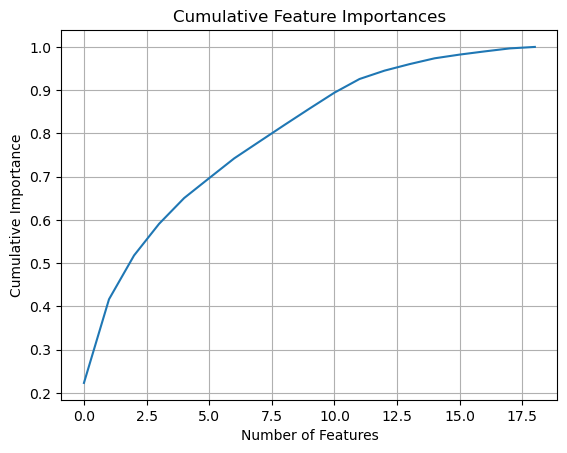

In [132]:
plt.plot(range(len(sorted_importances)), cumulative_importances)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importances')
plt.grid(True)
plt.show()

Первые по важности 19/20 признаков дают 99.1%/99.5% важности всех факторов в совокупности. Так что по сути, можно убрать 10-11 значений, ничего по сути не поменятеся, как я считаю. 

А вот и 11 самых бесполоезных значений. Следует ли их удалить!?

Если мы удалим неважные фичи, как мы будем объяснять заказчику, что они неважные?) 

случайные лес дает качество хуже, чем регрессия, хотя оно тоже довольно неплохое и проходное. Теперь проверим модель lightgbm, в нее я верю еще больше.

## Модель LightGBM

In [136]:
feature_names = final_tab.columns

In [137]:
print(feature_names)

Index(['start_temp', 'end_temp', 'time_heated_sec', 'total_power',
       'total_energy', 'Газ 1', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6',
       'Bulk 7', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1',
       'Wire 2', 'Wire 4', 'Wire 7', 'cooling_time'],
      dtype='object')


In [138]:
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

In [139]:
display(test_data)

In [140]:
param_grid2 = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [16, 31, 63, 127],
    'num_boost_round': [100, 300, 500, 1000],
    'early_stopping_rounds': [20, 50, 100]
}

In [141]:
%%time
lgb_model = lgb.LGBMRegressor()

random_search2 = RandomizedSearchCV(lgb_model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_absolute_error', cv=5)

random_search2.fit(x_train, y_train)

best_model2 = random_search2.best_estimator_
best_score2 = random_search2.best_score_
best_params2 = random_search2.best_params_
print(best_score2)
print(best_params2)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


In [142]:
cv_scores = cross_val_score(best_model2, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
mean_cv_score = cv_scores.mean()
print(cv_scores)
print(mean_cv_score)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[-6.12181271 -5.07044755 -5.80380619 -6.24025183 -6.47443638]
-5.942150932157192


## Маленькая придумка

Да, качество еще лучше. Можем ли мы еще улучшить качество? У меня 2 идеи: поискать выбросы, потому что мы временно пропустили этот процесс и попробовать сделать свой бустинг и первым слоем сделать в нем регрессию, потому что у нас отличные линейные связи и попробовать эту регрессию немнгожечко пробустить. 

In [143]:
base_model = LinearRegression()
base_predictions = cross_val_predict(base_model, x_train, y_train, cv=5)
base_mae = mean_absolute_error(y_train, base_predictions)

boosting_model = GradientBoostingRegressor(loss='absolute_error', n_estimators=100, learning_rate=0.1)
residuals = y_train - base_predictions
boosted_predictions = cross_val_predict(boosting_model, x_train, residuals, cv=5)
boosted_predictions = base_predictions + boosted_predictions
boosted_mae = mean_absolute_error(y_train, boosted_predictions)

print("Base Model MAE:", base_mae)
print("Boosted Model MAE:", boosted_mae)

Base Model MAE: 5.835573331439832
Boosted Model MAE: 5.709853093656883


Так мне больше нравится! На данный момент это лучшая модель. А теперь, когда мы убедились, что данные у нас адекватные и качественную модель построить можно и легко, я хочу вернуться в прошлое и прогнать наши данные и просеять их через сито времени подготовки. Или придумать альтернативный параметр. 

# Тестирование

Есть 2 стула : на одном тестирование на уже обученной модели, на другом надо объединить тренировочную и валидационную выборки, обучить на них новую модель с заданными гиперпараметрами и потом протестировать. (У обоих есть свои преимущества и свои недостатки, при чем зеркальные относительно друг друга) И парадокс в том, что куда бы я ни сел, меня обязательно просят пересесть. Поэтому я просто протестирую уже обученную модель, а потом пересяду, когда попросишь, потому что лично мне больше нравится обучать тестовую модель на объединенной выборке, т.к. у нас и без того данных мало. 

In [144]:
base_model = LinearRegression()
base_model.fit(x_train, y_train)
base_predictions2 = base_model.predict(x_test)
base_mae2 = mean_absolute_error(y_test, base_predictions2)

boosting_model2 = GradientBoostingRegressor(loss='absolute_error', n_estimators=100, learning_rate=0.1)
residuals2 = y_train - base_model.predict(x_train)
boosting_model2.fit(x_train, residuals2)
boosted_predictions2 = base_predictions2 + boosting_model2.predict(x_test)

boosted_mae2 = mean_absolute_error(y_test, boosted_predictions2)

print("Base Model MAE:", base_mae2)
print("Boosted Model MAE:", boosted_mae2)

Base Model MAE: 6.005457415902974
Boosted Model MAE: 5.896435642940579


Хочу обратить внимание, что хотя модель регрессии изначально дала низкий результат, как непроходной по заданию, так и намного ниже, чем на валидационной выборке. Настолько большой разницы для обычной регрессии я и правда не ожидал. Объяснить все это могу только ассиметричностью распределения данных и наличием выбросов, поскольку регрессия никак не связана с валидационной выборкой в процессе обучения. 

  # Вывод

Пока выводов немного, мне не очень понравился итоговый результат, даже если он и проходной, после такого результата на валидацинной выборке. Возможно, нам надо еще почитстить данные, например, убрать слишком долго остывающие партии... как вообще может сталь не застыть, если ее на ночь оставить? Возможно, есть какие-то температурные маркеры, придется это тоже изучить. Если менять random_state, может получиться совсем иная картина, но мы будем работать с тем, что имеем. Да и стоит один раз удалить несколько выбросов и выборки изменятся в корне. 

В общем я очень надеюсь на то, что ты посмотришь мою работу, укажешь мои ошибки и подскажешь, как улучшить мой проект так, чтобы он был достоин звания финального или выпускного.

## V 2.0

А вот теперь ситуация перевернулась с ног на голову. До удаления очередной партии выбросов ( раздел доработка данных) у меня был МАЕ на валидационной выборке 5.5, а на тестовой 6.55. После переработки занчение на тестовой стало 5.64, что уже не стыдно. В общем, переподгружу тетрадку, надеюсь, теперь мой проект произведет чуть более приятное впечатление. Тем не менее я еще в поисках зон роста и, надеюсь, ты мне что-нибудь еще подскажешь :)

## V 3.0

На этот раз я уже совсем не обеспокоен тем, что MAE на тестовой выборке повысился, потому что это просто дело выборки. Данные все еще очень кривые, даже несмотря на то, сколько мы удалили (я бы удалил больше и обосновал почему в пункте 6.2). В подтверждение моих слов работает разброс на кросс-валидациях, который достигает полутора пунктов (примерно 25%).

# Отчёт

## Выполнение плана

План был выполнен в полном объеме. Мы проанализировали данные под разными углами, нашли очень много неподходящих данных для нашей модели и выбросов. Затем мы создали общую таблицу признаков и целевого показателся, чтобы на основе него построить модели. Я не стал эксперементировать с регуляризаций в регрессии, зато создал на одну модель больше, чем планировал. Не стал отдельно исследовать регуляризацию, потому что после встречи в зуме я понял, что наша задача выглядит иначе, чем я представлял. 

## Трудности

В ходе проекта мне пришлось столкнуться с рядом трудностей. 

1)Пришлось осознать, как устроен процесс пороизводства и что от нас не требуется ничего связанного с экономией, только элементарное предсказание температуры. 

2)Мне не понравилось, как хранятся данные в таблицах bulk_time и wire_time, это затруднило (и, наверное, в моем случае загубило) создание единого таймлайна, по которому можно отследить процесс целиком. 

3)Трудно было определить, как поступить с данными, где время ожидания (остывания) слишком большое. Проблема, которую я тут вижу, что эти данные для нашей модели являются выбросами, потому что мы в каком-то роде прогнозируем измениения температуры в связи с нагреваними (но не остыванием). И это с одной стороны не очень хорошо, т.к. такие неэффективные процессы на нашем заводе случаются довольно регулярно, при этом у нас недостаточно данных, чтобы точнее научиться прогнозировать эти неффективные процессы. 

4)Для меня было непривычно оценивать важность факторов разными, я раньше этого не делал. 

5)Из-за большого разброса в данных качетво модели ощутимо скачет, что немного меня беспокоило, когда я получал более низкое качество модели. В итоге я начинал проверять другие random_state, чтобы успокоить себя и понять, что я делаю все правильно глобально, а качество ухудшилось потому, что какие-то объекты были удалены и это изменило тренировочную и валидационную выборки. Также помог потом переход на оценку моделей кросс-валидацией вместо валидационной выборки. 

Отвечая на вопрос, как я преодолевал эти трудности, ответ в каждом случае один и тот же - я тратил время на раешение возникшей проблемы. И чем больше тратил времени, тем лучше было решение.

## Ключевые шаги

1)Понимание процесса и конечной цели.

2)Хороший и разносторонний анализ данных. Понимание не только того, какие даныне у нас есть, но и то, что они подразумевают, как их можно трансформировать, где могут быть проблемы, выбросы, слабые места. 

3)Важно было бы с самого начала настроить оценку модели через кросс-валидацию, чтобы получать более сблансированную оценку и более точную обратную связь при дообработке данных.

## Итоговая модель

Моя итоговая модель - самодельный бустинг, который начинается с линейной регрессии, а потом ошибки прогнозируются при помощи GradientBoostingRegressor из Sklearn. Сделано это было изначально ради интереса. Хороших результатов я ожидал, потому что линейная регрессия сама по себе дала очень хороший результат по сравнению с "древесными" моделями. Итоговая метрика MAE на тестовой выборке равна 5.896. Показатель мог быть выше, но, как я уже объяснял, из-за разброса в данных и небольшого количетва этих самых данных итоговый показатель будет варьироваться примерно от 5.5 до 6.2 в зависимости от изначально заданного RANDOM_STATE и/или изменения выборки любым другим способом.

## Параметры

Парметры, которые я создал и стали основными: стартовая температура, время нагревания, время остывания, общие энергозатраты. Они и еще те параметры, которые были изначально, а именно легирующие добавки, газ  и провода участвуют в модели предсказааний. При этом 9-10 параметров добавок и проволоки мы можем убрать без потери качества. Также один параметр можно удалять как из-за мультиколинеарности, так и из-за бесполезности на выбор.

Что касается предобработки по созданным признакам, были убраны все партии, где температура ниже температуры плавления стали. Также были удалены все партии со слишком высоким коэффиицентом соотношения общего времени производства ко времени нагревания, так как это означает, что продукт слишком долго остывал в котле по несвязанным с производством причинам. 

##  Гиперпараметры

Гиперпараметров у регрессии нет, но есть у бустинга, при помщи которого мы предсказываем ошибки, они следующие : loss='absolute_error', n_estimators=100, learning_rate=0.1. У нас не было необходимости слишком сильно бустить модель на довольно скудных данных, чтобы избежать переобучения. 

## Улучшение модели

Улучшить модель можно с помощью:

1) увеличения количества данных. 

2) Получения более детальных отчетов по конкертным партиям от заказчика - нам надо лучше разобраться со слишком долгими остываниями. 

3) В теории можно было бы попробовать научиться предсказывать температуру за меньший период, чем партия, например, за каждое отдельное нагревание, остывание, перемешивание и т.д. для этого нам бы, возможно, понадобилось больше замеров температуры. Но это долгий и сложный процес, который может и не дать желаемого результата. Вопрос, есть ли у нас на это время и ресурсы. 